# Cats vs. Dogs Class Activation Maps
There will be only two classes: Cats and Dogs.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

## Download and Prepare the Dataset

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we can load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

In [2]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete35DU5K/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
# utility for preprocess the images and create batches before feeding it to our model.

def augment_images(image, label):
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize pixel values
  image = (image / 255)
  #resize image to 300 x 300
  image = tf.image.resize(image, (300, 300))

  return image, label

augmented_training_data = train_data.map(augment_images)

# shulling and creating batches
train_batches = augmented_training_data.shuffle(1024).batch(32)

# Build the Classifier


In [4]:
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 64)        0

In [5]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.RMSprop(lr=0.001))
model.fit(train_batches, epochs=25)

Epoch 1/25
582/582 [==============================] - 61s 81ms/step - loss: 0.6745 - accuracy: 0.5704
Epoch 2/25
582/582 [==============================] - 48s 80ms/step - loss: 0.6456 - accuracy: 0.6161
Epoch 3/25
582/582 [==============================] - 47s 79ms/step - loss: 0.6196 - accuracy: 0.6586
Epoch 4/25
582/582 [==============================] - 42s 71ms/step - loss: 0.5986 - accuracy: 0.6818
Epoch 5/25
582/582 [==============================] - 44s 73ms/step - loss: 0.5844 - accuracy: 0.6973
Epoch 6/25
582/582 [==============================] - 43s 72ms/step - loss: 0.5737 - accuracy: 0.7061
Epoch 7/25
582/582 [==============================] - 43s 71ms/step - loss: 0.5636 - accuracy: 0.7102
Epoch 8/25
582/582 [==============================] - 43s 71ms/step - loss: 0.5537 - accuracy: 0.7187
Epoch 9/25
582/582 [==============================] - 49s 81ms/step - loss: 0.5445 - accuracy: 0.7298
Epoch 10/25
582/582 [==============================] - 42s 70ms/step - loss: 0.535

# Building CAM(class activation maps) model


In [6]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(128, 1)

In [7]:
cam_model = Model(inputs=model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 64)        0

In [21]:
# display the class activation map of the image

def show_cam(image_value, features, results):

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()

# Testing the model
Download few images and see hoe the class activation maps look like.

In [22]:
!wget -O cat1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
!wget -O cat2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
!wget -O catanddog.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/catanddog.jpeg
!wget -O dog1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog1.jpeg
!wget -O dog2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog2.jpeg

--2023-11-05 05:05:57--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 142.251.162.207, 173.194.213.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.003s  

2023-11-05 05:05:57 (155 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2023-11-05 05:05:57--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 142.251.162.207, 173.194.213.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Sav

In [23]:
# function to preprocess the image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)

  # generate the CAM
  show_cam(tensor_image, features, results)

1/1 [==============================] - 0s 21ms/step
sigmoid output: [[0.21583766]]
prediction: cat


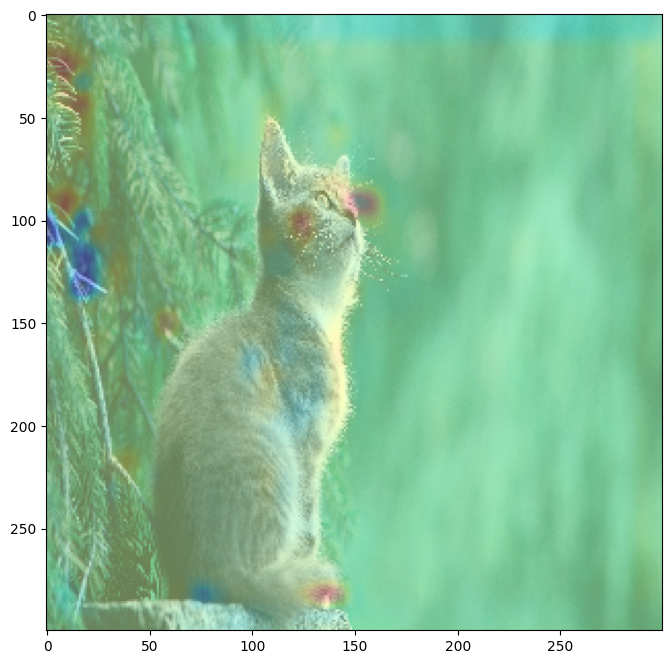

In [24]:
convert_and_classify('cat1.jpg')

1/1 [==============================] - 0s 47ms/step
sigmoid output: [[0.30355027]]
prediction: cat


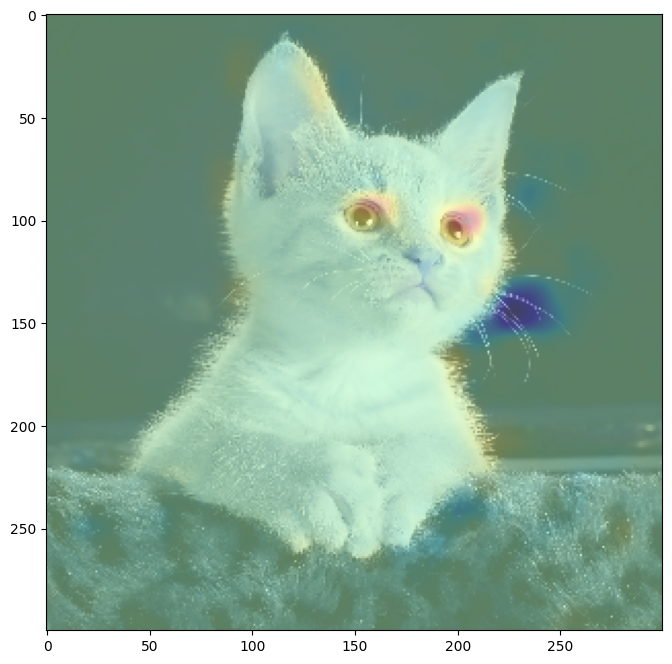

In [25]:
convert_and_classify('cat2.jpg')

1/1 [==============================] - 0s 124ms/step
sigmoid output: [[0.68184054]]
prediction: dog


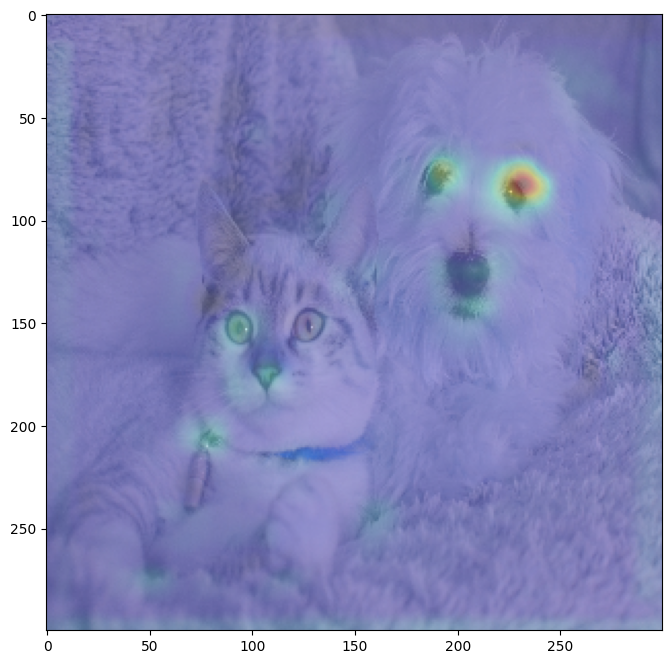

In [26]:
convert_and_classify('catanddog.jpg')

1/1 [==============================] - 0s 44ms/step
sigmoid output: [[0.62140656]]
prediction: dog


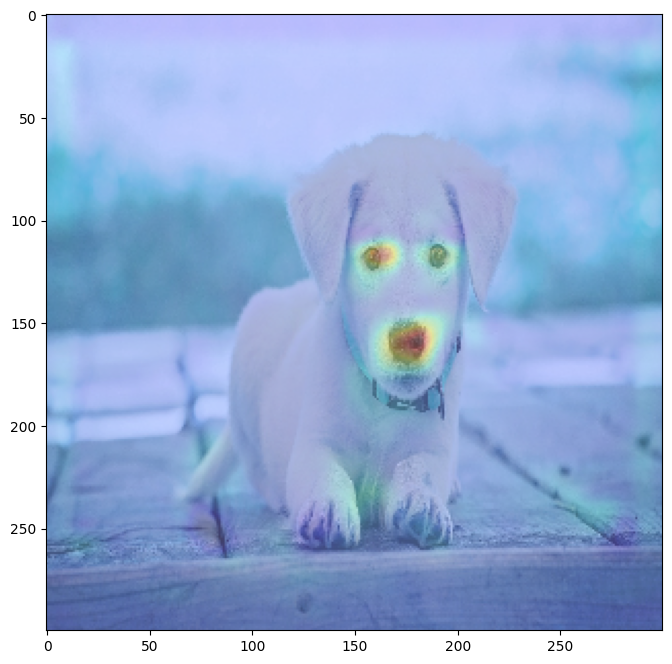

In [27]:
convert_and_classify('dog1.jpg')

1/1 [==============================] - 0s 22ms/step
sigmoid output: [[0.6057452]]
prediction: dog


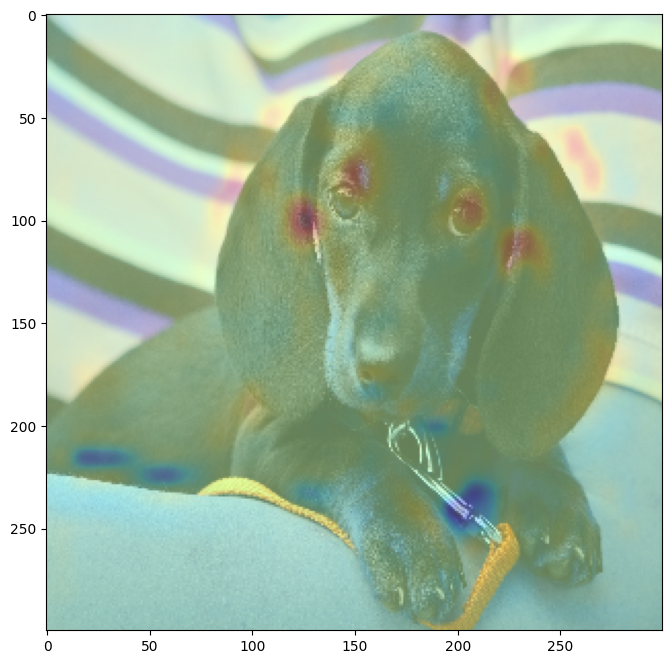

In [28]:
convert_and_classify('dog2.jpg')